### Extracting Dataset from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pavia_path = "/content/drive/MyDrive/Pansharpening_Data/pavia"
botswana_path = "/content/drive/MyDrive/Pansharpening_Data/botswana4"

In [ ]:
import numpy as np
from scipy.io import loadmat

def load_mat_flexible(mat_path: str):
    d = loadmat(mat_path)
    # remove meta keys
    keys = [k for k in d.keys() if not k.startswith("__")]
    meta = {k: np.array(d[k]).shape for k in keys}
    print("MAT keys & shapes:", meta)

load_mat_flexible(pavia_path + "/pavia_01/pavia_01.mat")

MAT keys & shapes: {'pan': (160, 160), 'ref': (160, 160, 102), 'y': (40, 40, 102)}


In [ ]:
# Inputs: Panchromatic Image (160,160,1) and LowRes MS Image (40,40,102)
# Output: HighRes MS Image (160,160,102)

### Converting to Tensorflow Dataset

In [ ]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from tensorflow.keras import optimizers


def normalize_bandwise(x):
    if x.ndim == 2:
        lo, hi = np.percentile(x, 1), np.percentile(x, 99)
        return np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)
    elif x.ndim == 3:
        out = np.zeros_like(x, dtype=np.float32)
        for b in range(x.shape[2]):
            lo, hi = np.percentile(x[...,b], 1), np.percentile(x[...,b], 99)
            out[...,b] = np.clip((x[...,b] - lo) / (hi - lo + 1e-6), 0, 1)
        return out
    else:
        raise ValueError("Unsupported ndim")

def load_sample(mat_path, scale=4):
    mat_path = mat_path.numpy().decode("utf-8")
    final_path = f"{pavia_path}/{mat_path}/{mat_path}.mat"
    # print("Loaded:", final_path)
    d = loadmat(final_path)
    pan = np.array(d['pan'], dtype=np.float32)    # (H,H)
    y_lr = np.array(d['y'], dtype=np.float32)     # (H/scale,H/scale,C)

    # normalize
    pan = normalize_bandwise(pan)
    y_lr = normalize_bandwise(y_lr)

    # expand pan -> (H,H,1)
    pan = pan[...,None]

    # upsample y to PAN resolution
    H_hr, W_hr = pan.shape[:2]
    y_up = tf.image.resize(y_lr, (H_hr, W_hr), method='bicubic').numpy()

    return y_up.astype(np.float32), pan.astype(np.float32), y_lr.astype(np.float32)

def tf_load_sample(path):
    y_up, pan, y_lr = tf.py_function(load_sample, [path], [tf.float32, tf.float32, tf.float32])
    y_up.set_shape([160,160,102])  # (H,H,C)
    pan.set_shape([160,160,1])      # (H,H,1)
    y_lr.set_shape([40,40,102])  # (H/scale,H/scale,C)
    return (y_up, pan, y_lr)

# -------------------------
# Build tf.data datasets
# -------------------------

def build_dataset(list_file, batch_size=4, shuffle=True):
    paths = [line.strip() for line in open(list_file)]
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if shuffle:
        ds = ds.shuffle(len(paths))
    ds = ds.map(tf_load_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_file = "/content/drive/MyDrive/Pansharpening_Data/pavia/train.txt"
val_file = "/content/drive/MyDrive/Pansharpening_Data/pavia/val.txt"

batch_size = 4

train_ds = build_dataset(train_file, batch_size=batch_size, shuffle=True)
val_ds   = build_dataset(val_file, batch_size=batch_size, shuffle=False)

### Dataset Visualization

y_up: (4, 160, 160, 102)
pan: (4, 160, 160, 1)
y_lr: (4, 40, 40, 102)


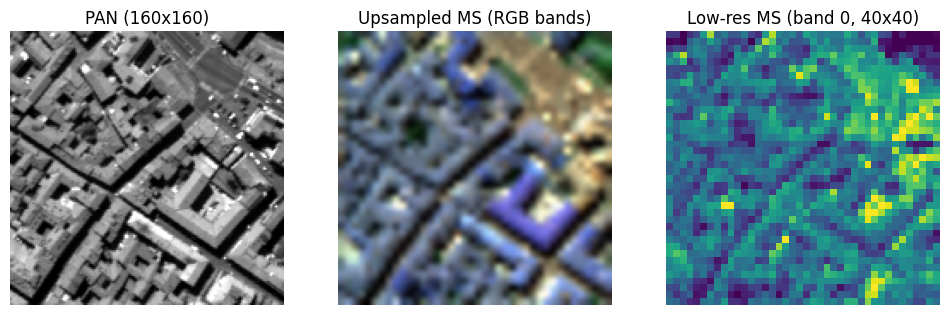

In [ ]:
import matplotlib.pyplot as plt

# Fetch one batch
for y_up, pan, y_lr in val_ds.take(1):
    print("y_up:", y_up.shape)   # (B,160,160,102)
    print("pan:", pan.shape)     # (B,160,160,1)
    print("y_lr:", y_lr.shape)   # (B,40,40,102)

    # Visualize first sample in the batch
    y_up_sample = y_up[0].numpy()
    pan_sample  = pan[0].numpy().squeeze()
    y_lr_sample = y_lr[0].numpy()

    # Choose 3 bands for RGB visualization (here arbitrarily 10, 30, 50)
    bands = [10, 30, 50]
    rgb_up = y_up_sample[..., bands]
    rgb_up = (rgb_up - rgb_up.min()) / (rgb_up.max() - rgb_up.min() + 1e-8)

    # Plot
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(pan_sample, cmap="gray")
    plt.title("PAN (160x160)")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(rgb_up)
    plt.title("Upsampled MS (RGB bands)")
    plt.axis("off")

    plt.subplot(1,3,3)
    # downsampled MS (first band example)
    plt.imshow(y_lr_sample[...,0], cmap="viridis")
    plt.title("Low-res MS (band 0, 40x40)")
    plt.axis("off")

    plt.show()

### Proposed Model Architecture

In [ ]:
from tensorflow.keras import layers, Model, optimizers
import numpy as np
import math

In [ ]:
class PatchEmbed(layers.Layer):
    """Convert 2-D image → flattened patches + positional embedding."""
    def __init__(self, patch_size=4, embed_dim=256, norm_layer=layers.LayerNormalization):
        super().__init__()
        self.patch_size = patch_size
        self.proj = layers.Conv2D(embed_dim, kernel_size=patch_size,
                                  strides=patch_size, use_bias=False)
        self.norm = norm_layer(epsilon=1e-6) if norm_layer else None

    def call(self, x):
        B, H, W, C = tf.unstack(tf.shape(x))
        x = self.proj(x)                       # (B, H/p, W/p, D)
        x = tf.reshape(x, [B, -1, x.shape[-1]]) # (B, N, D)
        if self.norm:
            x = self.norm(x)
        return x

In [ ]:
def mha_block(q, k, v, num_heads=8, name=None):
    attn = layers.MultiHeadAttention(num_heads=num_heads,
                                     key_dim=q.shape[-1]//num_heads,
                                     name=name)(q, k, v)
    return attn

In [ ]:
class AFormerBlock(layers.Layer):
    def __init__(self, dim, num_heads, mlp_ratio=4., dropout=0.1):
        super().__init__()
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.attn  = layers.MultiHeadAttention(num_heads, key_dim=dim//num_heads,
                                               dropout=dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        mlp_hidden = int(dim * mlp_ratio)
        self.mlp   = tf.keras.Sequential([
            layers.Dense(mlp_hidden, activation=tf.nn.gelu),
            layers.Dropout(dropout),
            layers.Dense(dim),
            layers.Dropout(dropout)
        ])

    def call(self, x, training=None):
        y = self.norm1(x)
        y = self.attn(y, y, training=training)
        x = x + y

        y = self.norm2(x)
        y = self.mlp(y, training=training)
        return x + y

In [ ]:
class CrossFusion(layers.Layer):
    """Queries from LR-MS leg, Keys/Values from PAN leg (or vice-versa)."""
    def __init__(self, dim, num_heads, dropout=0.1):
        super().__init__()
        self.norm_q = layers.LayerNormalization(epsilon=1e-6)
        self.norm_kv = layers.LayerNormalization(epsilon=1e-6)
        self.cross_attn = layers.MultiHeadAttention(num_heads,
                                                    key_dim=dim//num_heads,
                                                    dropout=dropout)

    def call(self, q_tokens, kv_tokens, training=None):
        q = self.norm_q(q_tokens)
        kv = self.norm_kv(kv_tokens)
        fused = self.cross_attn(q, kv, kv, training=training)
        return fused + q_tokens          # residual

In [ ]:
class AFormerDecoder(layers.Layer):
    def __init__(self, out_channels, patch_size=4):
        super().__init__()
        self.patch_size = patch_size
        self.head = layers.Conv2D(out_channels, kernel_size=1)

    def call(self, tokens, H, W):
        # tokens: (B, N, D)
        B, N, D = tf.unstack(tf.shape(tokens))
        p = self.patch_size
        h = H // p
        w = W // p
        x = tf.reshape(tokens, [B, h, w, D])
        x = tf.image.resize(x, [H, W], method='bilinear')
        x = self.head(x)               # (B, H, W, C)
        return x

In [ ]:
def build_aformer(
        pan_shape=(160,160,1),
        lr_shape=(40,40,102),
        patch_size=4,
        embed_dim=256,
        depth=6,
        num_heads=8,
        mlp_ratio=4.,
        dropout=0.1):

    # ---------- Inputs ----------
    pan_in = layers.Input(shape=pan_shape, name='pan')       # (160,160,1)
    lr_in  = layers.Input(shape=lr_shape, name='lr_ms')      # (40,40,102)

    # ---------- Upsample LR to PAN resolution (bicubic) ----------
    lr_up = layers.Lambda(lambda x: tf.image.resize(x, pan_shape[:2],
                                                    method='bicubic'),
                          name='lr_upsample')(lr_in)         # (160,160,102)

    # ---------- Patch embedding (both branches) ----------
    pan_embed = PatchEmbed(patch_size, embed_dim)(pan_in)    # (B, 160²/p², D)
    lr_embed  = PatchEmbed(patch_size, embed_dim)(lr_up)     # (B, 160²/p², D)

    # ---------- Encoder stacks (same depth) ----------
    pan_tokens = pan_embed
    lr_tokens  = lr_embed
    for i in range(depth):
        block = AFormerBlock(embed_dim, num_heads, mlp_ratio, dropout)
        pan_tokens = block(pan_tokens)
        lr_tokens  = block(lr_tokens)

    # ---------- Cross-attention fusion ----------
    fused_tokens = CrossFusion(embed_dim, num_heads, dropout)(lr_tokens, pan_tokens)

    # ---------- Decoder ----------
    decoder = AFormerDecoder(out_channels=lr_shape[-1], patch_size=patch_size)
    fused_hr = decoder(fused_tokens, H=pan_shape[0], W=pan_shape[1])   # (B,160,160,102)

    # ---------- Model ----------
    model = Model(inputs=[lr_in, pan_in], outputs=fused_hr, name='AFormer_Pansharpen')
    return model

In [ ]:
model = build_aformer()
model.summary()

Model: "AFormer_Pansharpen"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lr_ms (InputLayer)  │ (None, 40, 40,    │          0 │ -                 │
│                     │ 102)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lr_upsample         │ (None, 160, 160,  │          0 │ lr_ms[0][0]       │
│ (Lambda)            │ 102)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pan (InputLayer)    │ (None, 160, 160,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embed_1       │ (None, None, 256) │    418,304 │ lr_upsample[0][0] │
│ (PatchEmbed)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embed         │ (None, None, 256) │      4,608 │ pan[0][0]         │
│ (PatchEmbed)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_former_block      │ (None, None, 256) │    789,760 │ patch_embed[0][0… │
│ (AFormerBlock)      │                   │            │ patch_embed_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_former_block_1    │ (None, None, 256) │    789,760 │ a_former_block[0… │
│ (AFormerBlock)      │                   │            │ a_former_block[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_former_block_2    │ (None, None, 256) │    789,760 │ a_former_block_1… │
│ (AFormerBlock)      │                   │            │ a_former_block_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_former_block_3    │ (None, None, 256) │    789,760 │ a_former_block_2… │
│ (AFormerBlock)      │                   │            │ a_former_block_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_former_block_4    │ (None, None, 256) │    789,760 │ a_former_block_3… │
│ (AFormerBlock)      │                   │            │ a_former_block_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_former_block_5    │ (None, None, 256) │    789,760 │ a_former_block_4… │
│ (AFormerBlock)      │                   │            │ a_former_block_4… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_fusion        │ (None, None, 256) │    264,192 │ a_former_block_5… │
│ (CrossFusion)       │                   │            │ a_former_block_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_former_decoder    │ (None, 160, 160,  │     26,214 │ cross_fusion[0][… │
│ (AFormerDecoder)    │ 102)              │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,451,878 (20.80 MB)

 Trainable params: 5,451,878 (20.80 MB)

 Non-trainable params: 0 (0.00 B)

# Training Loop

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, optimizers

def downsample(x, factor=4):
    """Downsample tensor by factor using bicubic interpolation"""
    h = tf.shape(x)[1] // factor
    w = tf.shape(x)[2] // factor
    return tf.image.resize(x, (h, w), method='bicubic')

def spectral_loss(y_lr, fused_hr, factor=4):
    """Ensure downsampled fused matches observed LR MS"""
    fused_lr = downsample(fused_hr, factor)
    return tf.reduce_mean(tf.square(fused_lr - y_lr))

def spatial_loss(pan, fused_hr):
    """Ensure luminance of fused matches PAN"""
    lum = tf.reduce_mean(fused_hr, axis=-1, keepdims=True)
    return tf.reduce_mean(tf.square(lum - pan))

def total_variation_loss(fused_hr, weight=1e-4):
    return weight * tf.reduce_mean(tf.image.total_variation(fused_hr))

def unsupervised_loss(y_lr, pan, fused_hr, alpha=1.0, beta=1.0, gamma=1e-4):
    l_spec = spectral_loss(y_lr, fused_hr)
    l_spat = spatial_loss(pan, fused_hr)
    l_tv   = total_variation_loss(fused_hr, gamma)
    return alpha*l_spec + beta*l_spat + l_tv

In [ ]:
optimizer = optimizers.Adam(learning_rate=1e-4)

In [ ]:
@tf.function
def train_step(model, optimizer, pan, y_lr, y_up, alpha=1):
    with tf.GradientTape() as tape:
        fused = model([y_lr, pan], training=True)

        l1_loss = tf.reduce_mean(tf.abs(fused - y_up))

        # Structural similarity loss (1 - SSIM)
        ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(fused, y_up, max_val=1.0))

        loss = alpha * l1_loss + (1 - alpha) * ssim_loss

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [ ]:
EPOCHS = 30

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    steps = 0

    # Training
    for y_up, pan, y_lr in train_ds:
        loss = train_step(model, optimizer, pan, y_lr, y_up)
        epoch_loss += loss
        steps += 1

    train_loss = epoch_loss / steps

    # Validation
    val_loss = 0.0
    val_steps = 0
    for y_up, pan, y_lr in val_ds:
        fused = model([y_lr, pan], training=False)
        val_loss += tf.reduce_mean(tf.abs(fused - y_up))
        val_steps += 1

    val_loss = val_loss / val_steps

    print(f"Epoch {epoch+1:02d} – Train loss: {train_loss:.5f}, Val loss: {val_loss:.5f}")

Epoch 01 – Train loss: 0.12051, Val loss: 0.12995
Epoch 02 – Train loss: 0.11431, Val loss: 0.14468
Epoch 03 – Train loss: 0.11478, Val loss: 0.12743
Epoch 04 – Train loss: 0.11534, Val loss: 0.14009
Epoch 05 – Train loss: 0.10922, Val loss: 0.12659
Epoch 06 – Train loss: 0.10710, Val loss: 0.13266
Epoch 07 – Train loss: 0.10945, Val loss: 0.13178
Epoch 08 – Train loss: 0.12260, Val loss: 0.14172
Epoch 09 – Train loss: 0.12498, Val loss: 0.13173
Epoch 10 – Train loss: 0.11994, Val loss: 0.13996
Epoch 11 – Train loss: 0.12910, Val loss: 0.14997
Epoch 12 – Train loss: 0.14007, Val loss: 0.16473
Epoch 13 – Train loss: 0.12050, Val loss: 0.14313
Epoch 14 – Train loss: 0.11763, Val loss: 0.13278
Epoch 15 – Train loss: 0.11127, Val loss: 0.12511
Epoch 16 – Train loss: 0.11594, Val loss: 0.12202
Epoch 17 – Train loss: 0.10970, Val loss: 0.15729
Epoch 18 – Train loss: 0.11984, Val loss: 0.12642
Epoch 19 – Train loss: 0.11247, Val loss: 0.13370
Epoch 20 – Train loss: 0.12690, Val loss: 0.13148


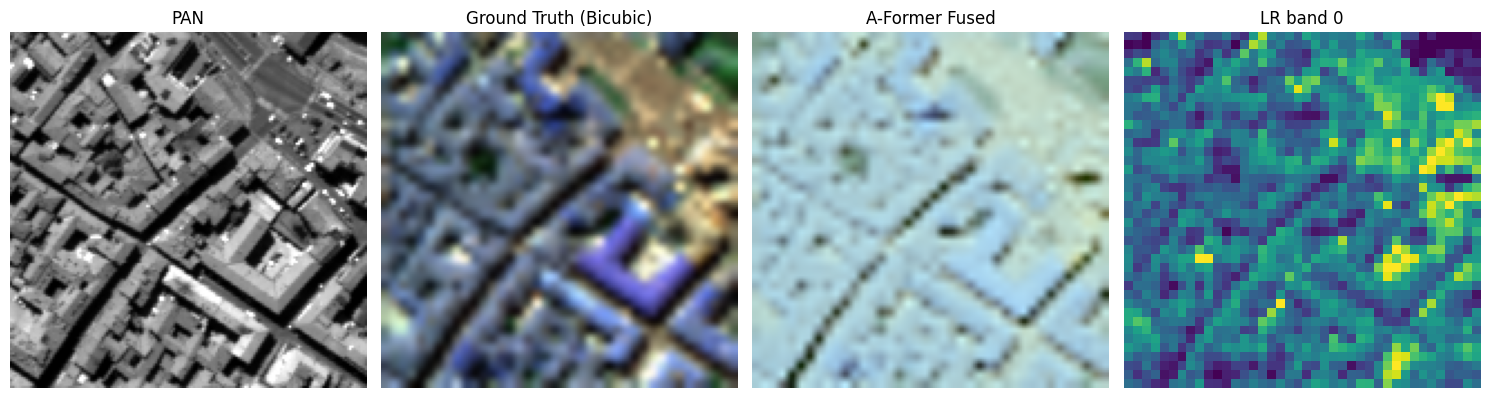

In [ ]:
def infer_one_sample(model, y_lr, pan):
    # Add batch dimension if needed and ensure proper shape
    if len(y_lr.shape) == 3:
        y_lr = tf.expand_dims(y_lr, 0)
    if len(pan.shape) == 3:
        pan = tf.expand_dims(pan, 0)

    fused = model([y_lr, pan], training=False)

    # Remove batch dimension for single sample
    if len(fused.shape) == 4:
        return fused[0].numpy()
    else:
        return fused.numpy()

# Grab a validation sample
for batch in val_ds.take(1):
    y_up, pan, y_lr = batch
    break

# Extract single samples correctly - convert tensors to numpy for display
y_up_sample = y_up[0].numpy() if len(y_up.shape) == 4 else y_up.numpy()
pan_sample = pan[0].numpy() if len(pan.shape) == 4 else pan.numpy()
y_lr_sample = y_lr[0].numpy() if len(y_lr.shape) == 4 else y_lr.numpy()

# Get fused result
fused = infer_one_sample(model, y_lr_sample, pan_sample)

# Plot RGB (bands 10,30,50) of the fused image
bands = [10, 30, 50]

# Handle different possible shapes and value ranges
def prepare_for_display(img, bands=None):
    """Prepare image for display with proper normalization"""
    if bands is not None and img.shape[-1] > 1:
        img = img[..., bands]

    # Normalize to [0,1] if needed
    if img.dtype != np.uint8:
        img_min = np.min(img)
        img_max = np.max(img)
        if img_max > img_min:  # Avoid division by zero
            img = (img - img_min) / (img_max - img_min)
        img = np.clip(img, 0, 1)

    return img

plt.figure(figsize=(15, 5))

# PAN image
plt.subplot(1, 4, 1)
pan_display = pan_sample.squeeze()  # Remove channel dimension for grayscale
plt.imshow(pan_display, cmap='gray')
plt.title('PAN')
plt.axis('off')

# Bicubic Upsample (Ground Truth)
plt.subplot(1, 4, 2)
y_up_display = prepare_for_display(y_up_sample, bands)
plt.imshow(y_up_display)
plt.title('Ground Truth (Bicubic)')
plt.axis('off')

# A-Former Fused
plt.subplot(1, 4, 3)
fused_display = prepare_for_display(fused, bands)
plt.imshow(fused_display)
plt.title('A-Former Fused')
plt.axis('off')

# LR band 0
plt.subplot(1, 4, 4)
lr_band0 = y_lr_sample[..., 0]  # First band of LR
plt.imshow(lr_band0, cmap='viridis')
plt.title('LR band 0')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def spectral_angle_mapper(img1, img2, eps=1e-8):

    assert img1.shape == img2.shape, "Both images must have same shape"

    # Flatten to (N, C)
    x = img1.reshape(-1, img1.shape[-1])
    y = img2.reshape(-1, img2.shape[-1])

    # Dot product and norms
    dot = np.sum(x * y, axis=1)
    norm_x = np.linalg.norm(x, axis=1)
    norm_y = np.linalg.norm(y, axis=1)

    cos_theta = np.clip(dot / (norm_x * norm_y + eps), -1, 1)
    sam = np.arccos(cos_theta)

    # Convert to degrees for interpretability
    sam_deg = np.degrees(sam)

    # Return mean SAM
    return np.nanmean(sam_deg)

# --- Compute SAM between fused and ground truth ---
sam_value = spectral_angle_mapper(fused, y_up_sample)
print(f"Spectral Angle Mapper (SAM): {sam_value:.4f}°")

Spectral Angle Mapper (SAM): 11.6863°
